#Berm Alert
RTS (January 2023)

Image classifiers to distinguish between open and closed/bermed creek mouths on the coast from Planet remote sensing data.

Here we apply two models: 
- A basic, custom CNN with dropout
- A transfer learning model

References:
- https://www.tensorflow.org/tutorials/images/classification
- https://www.tensorflow.org/tutorials/images/transfer_learning#data_preprocessing



```
Requires a home directory with subdirectories containing images of open and closed creek mouths. 

These images can be automatically downloaded from the Planet API using the get_Images_Planet.py script. 

Images must be classified manually.


data/
  images/
    ...
      open/
      closed/

```

In [1]:
### Import packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.metrics import confusion_matrix

# Import Images
Load .png images into train and validation datasets.

In [2]:
### Load Images + Describe
base_folder = '/content/drive/MyDrive/projects/berm_alert/'
data_folder = os.path.join(base_folder,'data/images/png/all_images/')
data_folder = pathlib.Path(data_folder)

sites = [
         'scott_creek',
         'san_lorenzo_river',
         'san_mateo_creek',
         'soquel_creek',
         'malibu_creek'
         ]

image_count = len(list(data_folder.glob('*/*.png')))
print('Total images in data folder: {}'.format(str(image_count)))

classes = [c for c in os.listdir(data_folder) if 'README' not in c]
print('Number of classes: {}'.format(str(len(classes))))
for c in classes:
  class_files = os.listdir(os.path.join(data_folder,c))
  print('  ' + c + ' - ' + str(len(class_files)) + ' images')


Total images in data folder: 2289
Number of classes: 2
  open - 1060 images
  closed - 1229 images


Open Berm Example:
/content/drive/MyDrive/projects/berm_alert/data/images/png/all_images/open/scott_creek_20210322_180548_35_241a_3B_Visual_clip.png


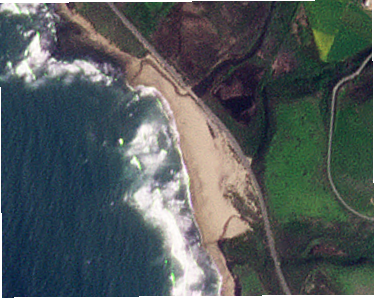



Closed Berm Example:
/content/drive/MyDrive/projects/berm_alert/data/images/png/all_images/closed/soquel_creek_20221021_175429_34_2435_3B_Visual_clip.png


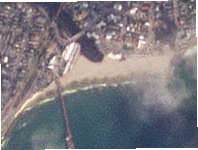

In [3]:
### Example Images
for c in classes:
  class_files = list(data_folder.glob(c + '/*.png'))
  if len(class_files) == 0:
    continue
  print('{} Berm Example:'.format(c.capitalize()))
  ex_im_file = str(class_files[np.random.randint(0, len(class_files))])
  print(ex_im_file)
  im = PIL.Image.open(ex_im_file)
  display(im)
  print('\n')


In [4]:
### Create TF Datasets
'''
Ref: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
'''

# Input parameters
seed = 0
val_split = 0.2
batch_size = 32
img_height = 180
img_width = 180
color_mode = 'rgb'

def ds_info(dataset):  # describe classess and images in a dataset
  for c in dataset.class_names:
    n_img = len([f for f in dataset.file_paths if c in f])
    print('  {}: {} images'.format(c,n_img))

# Create training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_folder,
  validation_split=val_split,
  subset="training",
  class_names = ['open','closed'],
  label_mode = 'binary', # binary, int
  color_mode = color_mode, # rgb, rgba
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

ds_info(train_ds)
print('\n')

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_folder,
  validation_split=val_split,
  subset="validation",
  class_names = ['open','closed'],
  label_mode = 'binary', # binary, int
  color_mode = color_mode, # rgb, rgba
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

ds_info(val_ds)

# Save Data for Later
class_names = train_ds.class_names
num_classes = len(class_names)

def data_from_tf_dataset(ds):
  unbatch = ds.unbatch()
  unbatch = list(unbatch.as_numpy_iterator()) # tuple with each pair an image and label
  images = [x[0] for x in unbatch]
  images = np.stack(images) # array (N_images, image width, image height, colors)
  labels = [int(x[1]) for x in unbatch] # array (N_images, )

  return images, labels

train_images, train_labels = data_from_tf_dataset(train_ds) 
print('\nTrain data stored in np arrays')
val_images, val_labels = data_from_tf_dataset(val_ds)
print('Val data stored in np arrays')


Found 2289 files belonging to 2 classes.
Using 1832 files for training.
  open: 833 images
  closed: 999 images


Found 2289 files belonging to 2 classes.
Using 457 files for validation.
  open: 227 images
  closed: 230 images

Train data stored in np arrays
Val data stored in np arrays


# Basic Model
Trains a basic CNN with dropout 

Ref:
https://www.tensorflow.org/tutorials/images/classification

In [6]:
### Define Model

# Performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Create Model
dropout = 0.2
image_shape = (img_height, img_width, len(color_mode))

basic_model = Sequential([
  layers.Rescaling(1./255, input_shape=image_shape),  # normalize pixels
  layers.Conv2D(16, len(color_mode), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(dropout),
  layers.Conv2D(32, len(color_mode), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(dropout),
  layers.Conv2D(64, len(color_mode), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(dropout),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


# Compile
basic_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

basic_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [7]:
### Train Model
epochs = 15

history = basic_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
58/58 [==============================] - 81s 1s/step - loss: 0.7481 - accuracy: 0.5573 - val_loss: 0.6627 - val_accuracy: 0.6061
Epoch 2/15
58/58 [==============================] - 62s 1s/step - loss: 0.5961 - accuracy: 0.6779 - val_loss: 0.5373 - val_accuracy: 0.7746
Epoch 3/15
58/58 [==============================] - 62s 1s/step - loss: 0.4351 - accuracy: 0.7904 - val_loss: 0.4105 - val_accuracy: 0.8031
Epoch 4/15
58/58 [==============================] - 67s 1s/step - loss: 0.3527 - accuracy: 0.8461 - val_loss: 0.3310 - val_accuracy: 0.8600
Epoch 5/15
58/58 [==============================] - 63s 1s/step - loss: 0.2908 - accuracy: 0.8755 - val_loss: 0.2991 - val_accuracy: 0.8884
Epoch 6/15
58/58 [==============================] - 62s 1s/step - loss: 0.2369 - accuracy: 0.9023 - val_loss: 0.2424 - val_accuracy: 0.9125
Epoch 7/15
58/58 [==============================] - 66s 1s/step - loss: 0.2076 - accuracy: 0.9159 - val_loss: 0.2212 - val_accuracy: 0.9234
Epoch 8/15
58/58 [==

In [8]:
### Training and Validation Sensitivity/Specificity

def basic_predict(model, images):  # run model and make binary predictions
  '''
  Make predictions with image data with the basic model
  '''

  probs = tf.nn.softmax(model.predict(images))
  pred = [np.argmax(s) for s in probs] # binary
  pred_probs = [np.max(s) for s in probs] # probabilities

  return pred, pred_probs

def eval_model(pred, labels):  # determine model accuracy, sensitivity, specificity
  ''' 
  labels/predictions are arrays of 0s or 1s
  '''

  cm = confusion_matrix(labels, pred)
  sens = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # sensitivity - TP / TP + FN
  spec = cm[0, 0] / (cm[0, 1] + cm[0, 0])  # specificity - TN / TN + FP
  acc = (cm[0, 0] + cm[1, 1]) / (cm[0, 0] + cm[1, 1] + cm[0, 1] + cm[1, 0])

  print('\naccuracy: {}'.format(np.round(acc,5)))
  print('sensitivity (closed acc): {}'.format(np.round(sens,5)))
  print('specificity (open acc): {}'.format(np.round(spec,5)))


print('Training Performance (Basic Model):')
train_pred, _ = basic_predict(basic_model, train_images)
eval_model(train_pred, train_labels)

print('\nValidation Performance (Basic Model):')
val_pred, _ = basic_predict(basic_model, val_images)
eval_model(val_pred, val_labels)

Training Performance (Basic Model):
58/58 [==============================] - 17s 291ms/step

accuracy: 0.97871
sensitivity (closed acc): 0.99199
specificity (open acc): 0.96279

Validation Performance (Basic Model):
15/15 [==============================] - 4s 250ms/step

accuracy: 0.92123
sensitivity (closed acc): 0.96087
specificity (open acc): 0.88106


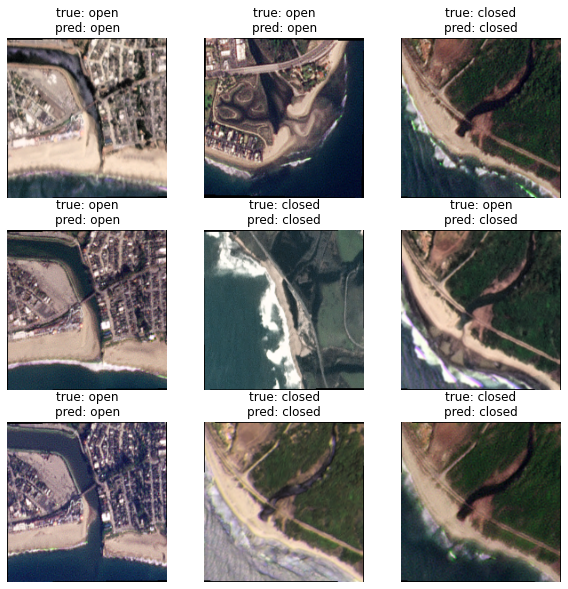

In [12]:
### Example Images and Predictions
plt.figure(figsize=(10, 10))
c = np.random.randint(0, len(val_labels) - 10) # pick from somewhere in dataset
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)

  plt.imshow(val_images[i + c].astype("uint8"))
  plt.title('true: ' + class_names[int(val_labels[i+c])] +\
            '\npred: ' + class_names[int(val_pred[i+c])])
  plt.axis("off")

In [17]:
# Save model for future use
model_folder = os.path.join(base_folder,'models/')
basic_model.save(os.path.join(model_folder, 'basic_model.h5'))

## To reload model:
basic_model_reload = tf.keras.models.load_model(os.path.join(model_folder, 'basic_model.h5'))
basic_model_reload.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

# Summary:
The model can accurate distinguish if a coastal stream is open or bermed from remote sensing imagery. This tool can be used by resource managers to remotely monitor a creek that is of concern for impacts to water quality, sediment transport, or fish passage.

Next steps in development of Berm Alert include:

- Test models on images from an unseen beach
- Visualize where in images the models are focusing
- Apply a transfer learning approach to retrain a community model that already understands beach features
- Integrate into data pipeline to automate Berm Alerts